<a href="https://colab.research.google.com/github/sayanbanerjee32/open_clip_demo/blob/main/openClip_Gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install open_clip_torch
!pip install gradio

In [ ]:
import os
import numpy as np
import torch

import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict


import open_clip


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# model, _, preprocess = open_clip.create_model_and_transforms('convnext_base_w', pretrained='laion2b_s13b_b82k_augreg')

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Context length: 77
Vocab size: 49408


In [ ]:
# cifar10 = CIFAR10('.', transform=preprocess, download=True)

In [ ]:
# images in skimage to use and their textual descriptions
# descriptions = {
#     "page": "a page of text about segmentation",
#     "chelsea": "a facial photo of a tabby cat",
#     "astronaut": "a portrait of an astronaut with the American flag",
#     "rocket": "a rocket standing on a launchpad",
#     "motorcycle_right": "a red motorcycle standing in a garage",
#     "camera": "a person looking at a camera on a tripod",
#     "horse": "a black-and-white silhouette of a horse",
#     "coffee": "a cup of coffee on a saucer"
# }

#labels for download
target_labels = ["page","chelsea","astronaut","rocket",
                 "motorcycle_right","camera","horse","coffee",
                 'logo']

In [ ]:
all_names = []
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    all_names.append(os.path.splitext(filename)[0])

set(all_names)

{'astronaut',
 'brick',
 'camera',
 'cell',
 'chelsea',
 'chessboard_GRAY',
 'chessboard_RGB',
 'clock_motion',
 'coffee',
 'coins',
 'color',
 'grass',
 'gravel',
 'horse',
 'hubble_deep_field',
 'ihc',
 'logo',
 'microaneurysms',
 'moon',
 'motorcycle_left',
 'motorcycle_right',
 'page',
 'phantom',
 'retina',
 'rocket',
 'text'}

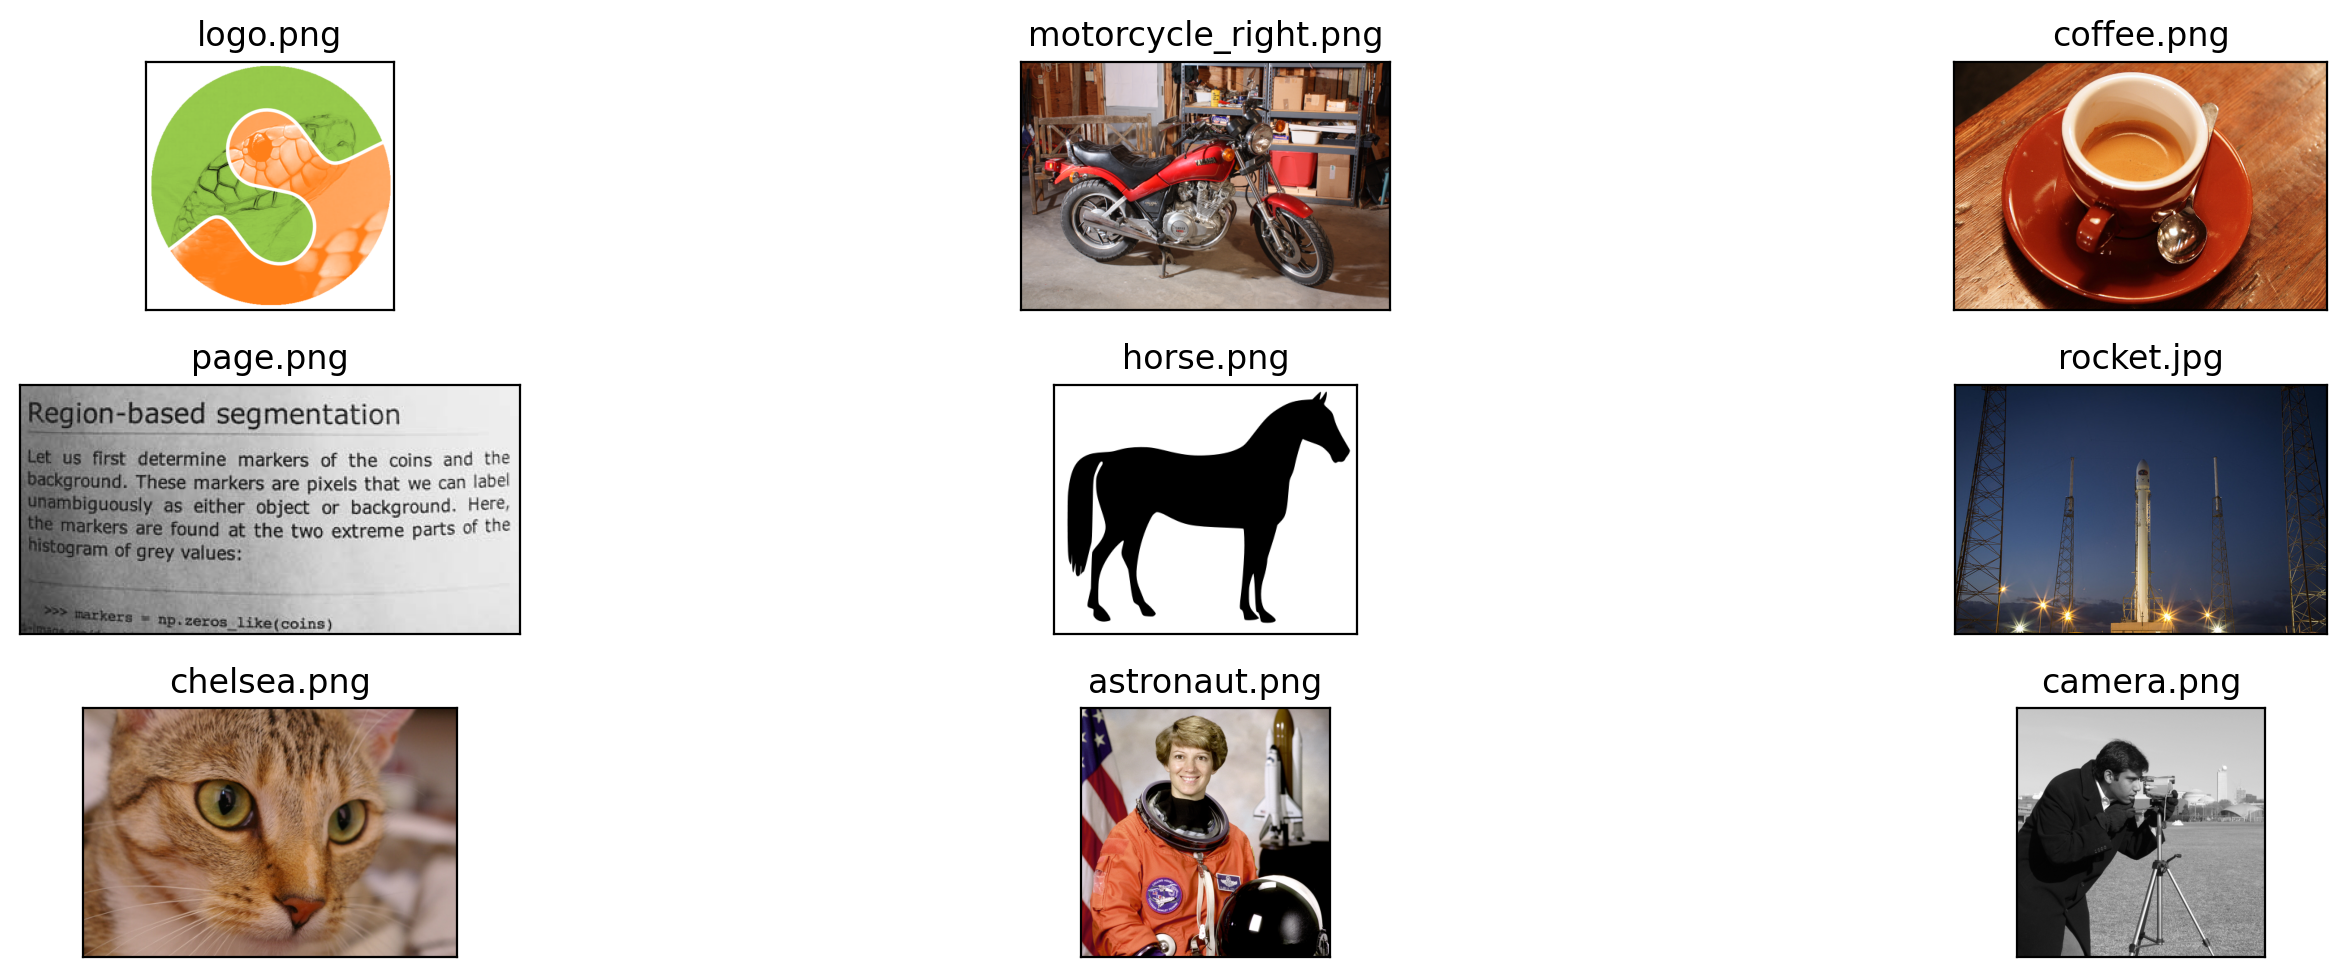

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in target_labels:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(3, 3, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    # texts.append(descriptions[name])

plt.tight_layout()


In [ ]:
image_input = torch.tensor(np.stack(images))
with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

image_features.size()

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


torch.Size([12, 512])

In [23]:
input_description = "A animal in black and white"
text_tokens = tokenizer([input_description])

In [24]:
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T)#.softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(1, dim=-1)

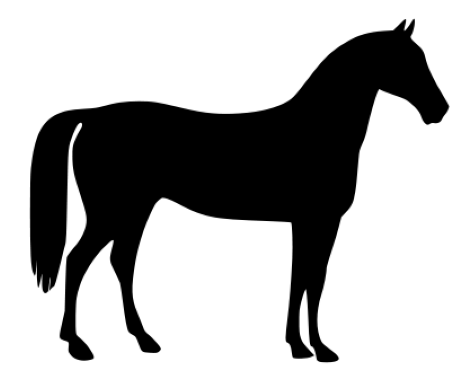

In [25]:
# plt.rcParams["axes.grid"] = False
plt.axis('off')
plt.imshow(original_images[top_probs.argmax().item()])

# For Gradio app

In [2]:
from huggingface_hub import HfApi
from google.colab import userdata
userdata.get('HF_TOKEN')
api = HfApi()

In [3]:
# assignment repo
!git clone https://github.com/sayanbanerjee32/open_clip_demo.git

Cloning into 'open_clip_demo'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 4), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (18/18), 6.83 KiB | 6.83 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
## move python files to outside
!mv open_clip_demo/app.py .

In [5]:
import app

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


## Push to Spaces

In [6]:
import os
os.makedirs('to_upload', exist_ok=True)

In [7]:
!cp app.py to_upload
!cp open_clip_demo/requirements.txt to_upload

In [8]:

api.upload_folder(
    folder_path="./to_upload",
    repo_id="sayanbanerjee32/open_clip_demo",
    repo_type="space",
)


CommitInfo(commit_url='https://huggingface.co/spaces/sayanbanerjee32/open_clip_demo/commit/d44bcd843c909f0a959f897169060ed4b436ba79', commit_message='Upload folder using huggingface_hub', commit_description='', oid='d44bcd843c909f0a959f897169060ed4b436ba79', pr_url=None, pr_revision=None, pr_num=None)